### House Price Prediction 
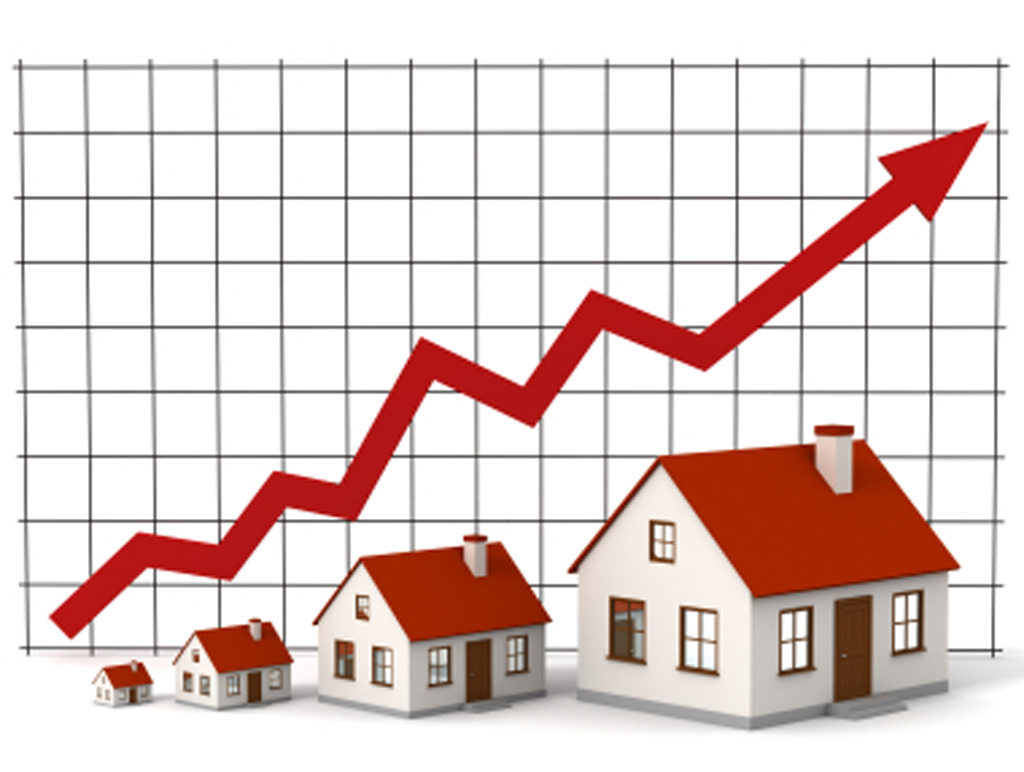

#### To solve this problem, we first need to analyse the dataset, find out patterns and relations between the features and use those features to train the model to give accurate predictions. Following is the POC for this action plan.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.model_selection import train_test_split
import xgboost
from sklearn.impute import KNNImputer
from sklearn.model_selection import KFold
import matplotlib.ticker as mtick
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor


In [2]:
df = pd.read_excel('dataset.xlsx', sheet_name='jul20-dataset')
df.sold_date.head(5)
df['sold_date_year'] = df['sold_date'].dt.year
df['sold_date_month'] = df['sold_date'].dt.month
df['sold_date_dayofweek'] = df['sold_date'].dt.dayofweek

In [3]:
df.corr()

,id,thoroughfare_id,census2016_settlement_geogid,local_authority_id,new_home_ind,sold_price,lat,lon,building_shape_area_value,sqm_value,yoc_value,storey_value,beds_value,baths_value,sold_date_year,sold_date_month,sold_date_dayofweek
id,1.000000,0.032055,-0.057961,-0.034532,0.004594,-0.010262,0.031924,0.022498,0.043143,-0.021867,0.046707,-0.039779,0.008393,0.047562,0.018287,-0.000442,-0.015115
thoroughfare_id,0.032055,1.000000,-0.195974,-0.236989,0.329795,0.047130,0.035426,0.070237,-0.072265,0.010790,0.132668,0.067368,0.052368,0.001440,0.038729,0.037532,0.024859
census2016_settlement_geogid,-0.057961,-0.195974,1.000000,0.291527,-0.141033,0.010543,-0.506232,-0.322711,-0.070236,-0.065521,-0.219768,0.062402,-0.040790,-0.200413,-0.071818,-0.001027,0.002721
local_authority_id,-0.034532,-0.236989,0.291527,1.000000,-0.121338,-0.022557,0.464671,-0.125317,-0.099913,-0.281561,-0.204072,-0.156025,-0.288623,-0.151138,0.031800,-0.007554,-0.067073
new_home_ind,0.004594,0.329795,-0.141033,-0.121338,1.000000,0.066684,0.102379,0.090942,-0.015497,0.025308,0.212729,-0.055487,0.000727,-0.035952,0.017791,0.016415,0.038451
sold_price,-0.010262,0.047130,0.010543,-0.022557,0.066684,1.000000,-0.196795,0.326830,0.557378,0.737942,-0.121683,0.341199,0.506870,0.483998,0.207914,0.035818,0.039200
lat,0.031924,0.035426,-0.506232,0.464671,0.102379,-0.196795,1.000000,-0.064144,-0.129096,-0.282515,0.031249,-0.219896,-0.261155,0.039135,0.096828,-0.000943,-0.030492
lon,0.022498,0.070237,-0.322711,-0.125317,0.090942,0.326830,-0.064144,1.000000,0.428909,0.337382,0.119537,0.062360,0.243646,0.279267,0.022811,0.073145,-0.010107
building_shape_area_value,0.043143,-0.072265,-0.070236,-0.099913,-0.015497,0.557378,-0.129096,0.428909,1.000000,0.684708,0.101786,-0.062645,0.462519,0.245619,-0.012862,0.006382,-0.040201
sqm_value,-0.021867,0.010790,-0.065521,-0.281561,0.025308,0.737942,-0.282515,0.337382,0.684708,1.000000,-0.095497,0.478166,0.804533,0.581962,-0.021284,-0.020825,0.033341


AxesSubplot(0.125,0.125;0.62x0.755)


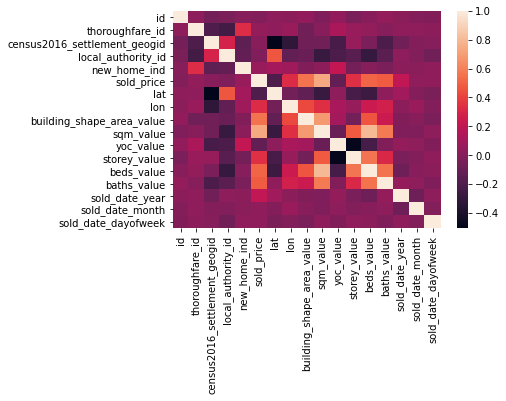

In [4]:
print(sns.heatmap(df.corr()))

we can see columns like id, thoroughfare_id,census2016_settlement_geogid does not have such strong correlation hence we can drop those. As the postal address is unique mostly and we already have information about EIRCODE, dropping postal address column would also make computation easy.

In [5]:
df.describe()

,id,thoroughfare_id,census2016_settlement_geogid,local_authority_id,new_home_ind,sold_price,lat,lon,building_shape_area_value,sqm_value,yoc_value,storey_value,beds_value,baths_value,sold_date_year,sold_date_month,sold_date_dayofweek
count,2.500000e+03,2.500000e+03,2482.000000,2500.000000,2500.000000,2.500000e+03,2500.000000,2500.000000,1054.000000,1613.000000,1972.000000,2213.000000,1319.000000,513.000000,2500.000000,2500.000000,2500.000000
mean,9.773428e+05,1.200014e+09,33502.701853,28.345600,0.038800,3.801953e+05,53.333294,-6.241923,79.314519,92.658138,1968.222617,1.519657,2.732373,1.594542,2015.634800,7.177200,2.381200
std,5.496987e+05,1.008168e+04,6649.170534,1.050429,0.193157,3.012048e+05,0.038975,0.063358,31.697632,48.614109,43.015915,0.614912,1.239379,1.011327,2.378338,3.383723,1.455999
min,6.610000e+02,1.200000e+09,4009.000000,25.000000,0.000000,5.000000e+04,53.188403,-6.365140,42.587210,-1.000000,1790.000000,1.000000,1.000000,0.000000,2010.000000,1.000000,0.000000
25%,5.306000e+05,1.200008e+09,35001.000000,28.000000,0.000000,2.100000e+05,53.300924,-6.277082,54.055775,60.100000,1934.000000,1.000000,2.000000,1.000000,2014.000000,4.000000,1.000000
50%,9.598860e+05,1.200011e+09,35001.000000,29.000000,0.000000,3.000000e+05,53.342428,-6.261079,73.090297,77.400000,1990.000000,1.000000,2.000000,1.000000,2016.000000,7.000000,3.000000
75%,1.436644e+06,1.200015e+09,35001.000000,29.000000,0.000000,4.500000e+05,53.352133,-6.231682,94.355364,112.470000,2000.000000,2.000000,4.000000,2.000000,2018.000000,10.000000,4.000000
max,1.946919e+06,1.200046e+09,35007.000000,29.000000,1.000000,3.795000e+06,53.421220,-6.053434,208.259904,447.760000,2019.000000,4.000000,11.000000,8.000000,2019.000000,12.000000,6.000000


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


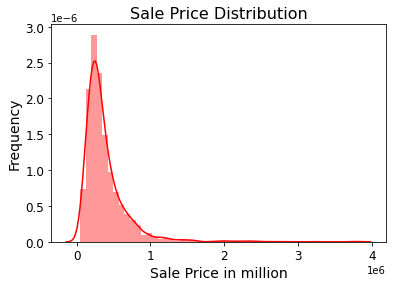

In [6]:

sns.distplot(df['sold_price'], color = 'r')
plt.title('Sale Price Distribution', fontsize = 16)
plt.xlabel('Sale Price in million', fontsize = 14)
plt.ylabel('Frequency', fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.savefig('distplot.png')
plt.show()

In [7]:
df=df.drop(['sold_date','census2016_small_area_geogid'],axis=1)


Text(0.5, 1.0, 'Percentage of missing values per feature')

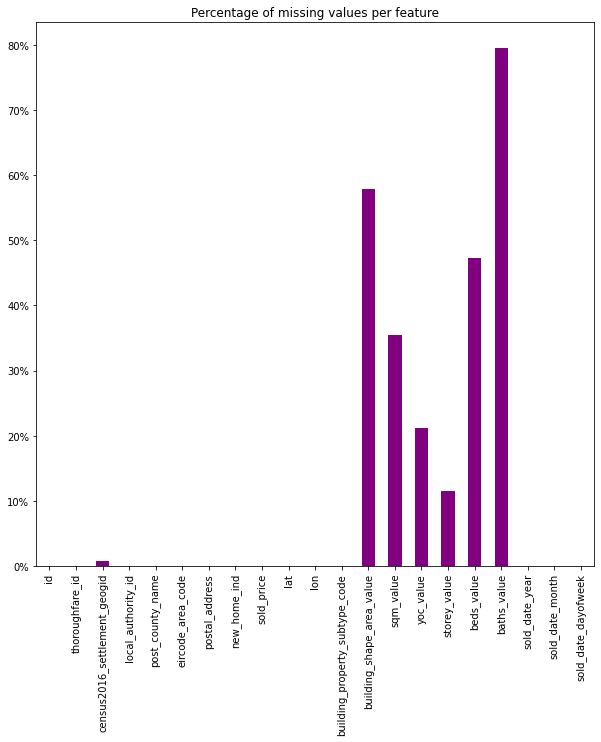

In [8]:
import matplotlib.ticker as mtick

df.isna().sum()
plt.figure(figsize = (10,10)) 
ax = (df.isnull().mean() * 100).plot(kind='bar', color ='purple')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.title('Percentage of missing values per feature')

we can see that 80% of baths_value is missing and 50% of beds_value is missing and around 60% of property_subtype code is missing. As these are important features we can not just drop these columns. Hence, the right way to solve this issue is to impute these values using KNN Imputer. 

After analysis it was observed that #SEMI_DETACHED, SEMIDETACHED, semi-detached, semidetached are similar so combining these values as one


In [9]:
#SEMI_DETACHED, SEMIDETACHED, semi-detached, semidetached are similar so combining these values as one
df["building_property_subtype_code"].replace({"SEMI_DETACHED": "semi-detached", "SEMIDETACHED": "semi-detached", "semidetached": "semi-detached"}, inplace=True)



### Performing EDA

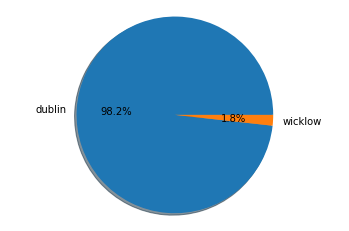

In [10]:
labels = df['post_county_name'].astype('category').cat.categories.tolist()
counts = df['post_county_name'].value_counts()
sizes = [counts[var_cat] for var_cat in labels]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True) #autopct is show the % on plot
ax1.axis('equal')
plt.show()


In [11]:
df_max = df.groupby('sold_date_year', as_index=False)['sold_price'].mean()
df_max= df_max.sort_values("sold_date_year")

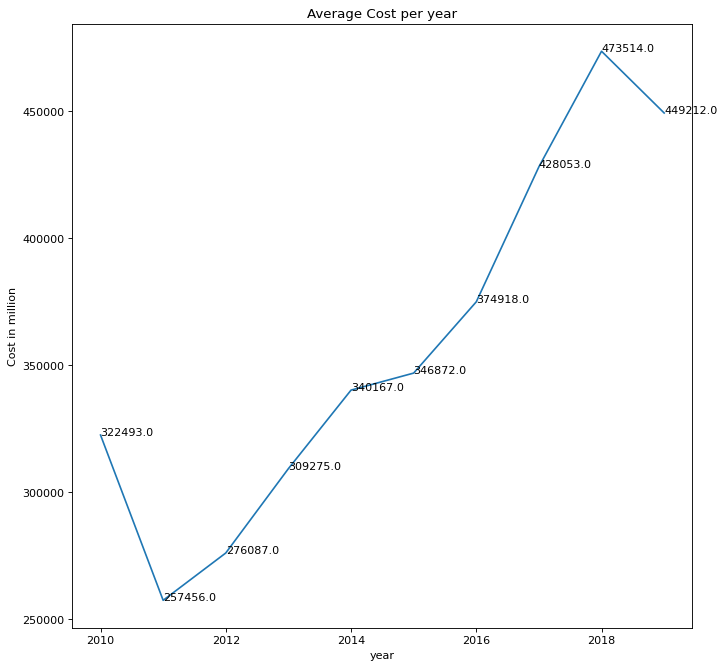

In [12]:
plt.figure(figsize=(10,10), dpi= 80)

plt.plot(df_max['sold_date_year'],np.ceil(df_max['sold_price']))
plt.xlabel('year')
plt.ylabel('Cost in million')
plt.title("Average Cost per year")
for a,b in zip(df_max['sold_date_year'], np.ceil(df_max['sold_price'])): 
    plt.text(a, b, str(b))

plt.savefig('3.png')

In [13]:
df_eir = df.groupby('eircode_area_code', as_index=False)['sold_price'].mean()
df_eir = df_eir.sort_values("sold_price",ascending=False)
df_eir

,eircode_area_code,sold_price
6,D06,1.232417e+06
11,D18,1.230190e+06
1,A96,6.164663e+05
0,A94,5.897914e+05
10,D14,5.672031e+05
5,D04,4.542768e+05
9,D13,4.154468e+05
4,D02,4.070897e+05
2,A98,3.996591e+05
3,D01,2.795015e+05


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


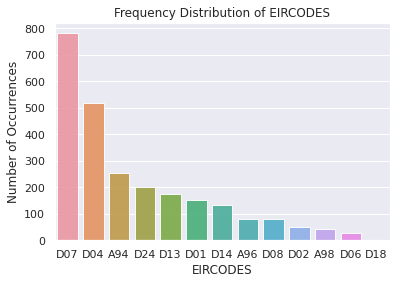

<Figure size 432x288 with 0 Axes>

In [14]:
import seaborn as sns
eir_count = df['eircode_area_code'].value_counts()
sns.set(style="darkgrid")
sns.countplot
sns.barplot(eir_count.index, eir_count.values, alpha=0.9)
plt.title('Frequency Distribution of EIRCODES')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('EIRCODES', fontsize=12)
plt.show()
plt.savefig('4.png')

In [15]:
df_eir = df.groupby('eircode_area_code', as_index=False)['sold_price'].mean()
df_eir_max = df.groupby('eircode_area_code', as_index=False)['sold_price'].max()
df_eir_min = df.groupby('eircode_area_code', as_index=False)['sold_price'].min()

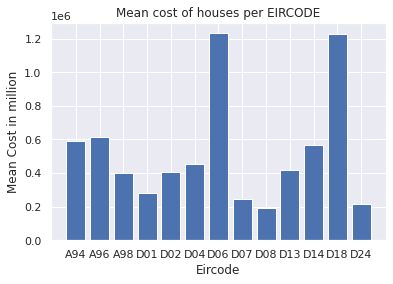

In [16]:
plt.bar(df_eir['eircode_area_code'],df_eir['sold_price'])
plt.xlabel('Eircode')
plt.ylabel('Mean Cost in million')
plt.title("Mean cost of houses per EIRCODE")
plt.savefig('5.png')

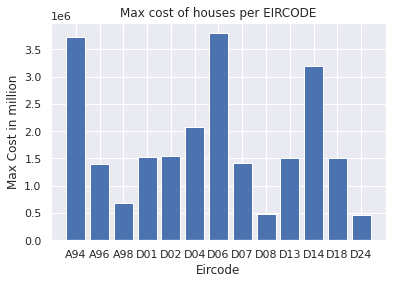

In [17]:
plt.bar(df_eir_max['eircode_area_code'],df_eir_max['sold_price'])
plt.xlabel('Eircode')
plt.ylabel('Max Cost in million')
plt.title("Max cost of houses per EIRCODE")
plt.savefig('6.png')

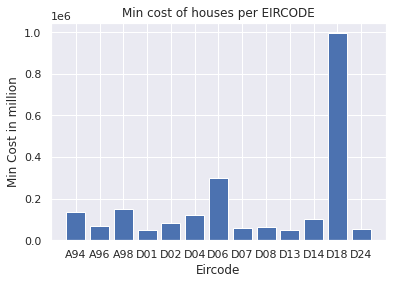

In [18]:
plt.bar(df_eir_min['eircode_area_code'],df_eir_min['sold_price'])
plt.xlabel('Eircode')
plt.ylabel('Min Cost in million')
plt.title("Min cost of houses per EIRCODE")
plt.savefig('7.png')

d06 and d18 are most expensive regions. while D06 has the highest sale value, d18 has the least different between min and max cost. both nearing 100k euros. 
it is to be noted that both of these regions have lesser number of sales which could be a result of consistently higher prices. 
in conlusion, we can say that both these areas have highly priced houses

In [19]:
def get_var_dtype_list(df):
    cat_cols = []
    num_cols = []

    for col in df.columns:
        if df[col].dtypes == 'object':
            cat_cols.append(col)
        else:
            num_cols.append(col)
    return (cat_cols, num_cols)


In [20]:
df = df.drop('postal_address',axis=1)

cat_cols, num_cols = get_var_dtype_list(df)
print("Categorical columns",cat_cols)
print("Numerical columns",num_cols)



Categorical columns ['post_county_name', 'eircode_area_code', 'building_property_subtype_code']
Numerical columns ['id', 'thoroughfare_id', 'census2016_settlement_geogid', 'local_authority_id', 'new_home_ind', 'sold_price', 'lat', 'lon', 'building_shape_area_value', 'sqm_value', 'yoc_value', 'storey_value', 'beds_value', 'baths_value', 'sold_date_year', 'sold_date_month', 'sold_date_dayofweek']


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


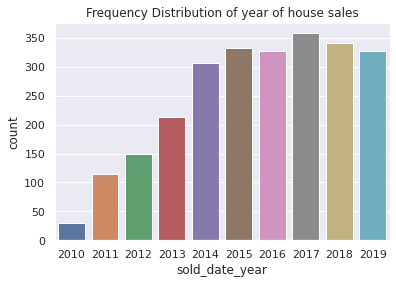

In [21]:
sns.countplot(df['sold_date_year'])

plt.title('Frequency Distribution of year of house sales')

plt.savefig('8.png')

Sales consistently increased till 2015 and we can see the maximum sale in the year 2017.

> Indented block







/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


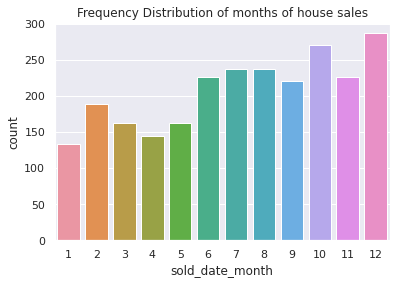

In [22]:
sns.countplot(df['sold_date_month'])

plt.title('Frequency Distribution of months of house sales')
plt.savefig('9.png')

from this graph we can see that the 2nd half of the year generally sees more amount of sales peaking in december owing to the festive season.

In [23]:
df_month = df.groupby('sold_date_month', as_index=False)['sold_price'].mean()
df_month = df_month.sort_values('sold_price')
#df_month

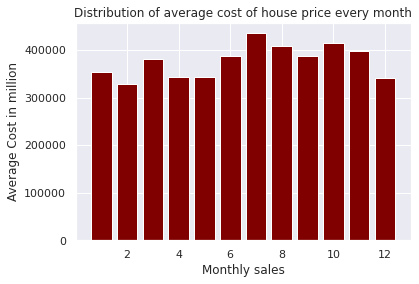

In [24]:
plt.bar(df_month['sold_date_month'],df_month['sold_price'],color='maroon')
plt.xlabel('Monthly sales')
plt.ylabel('Average Cost in million')
plt.title("Distribution of average cost of house price every month")
plt.savefig('10.png')

Owing to the festive season and the rising demand that has led to a high number of units sold in the second half of the year. It is possible there might be few offers involved affecting the prices to drop slightly in this situation.

Another hypothesis could be that may be there must be a rule among the brokers that they want to sell the houses before the year end and therefore, to sell off these houses, the cost of these houses are reduced so the sale goes up. 



In [25]:
df_subtype = df.groupby('building_property_subtype_code', as_index=False)['sold_price'].mean()
df_subtype = df_subtype.sort_values('sold_price')
#df_subtype

Text(0.5, 1.0, 'Distribution of building property subtype wrt max house price')

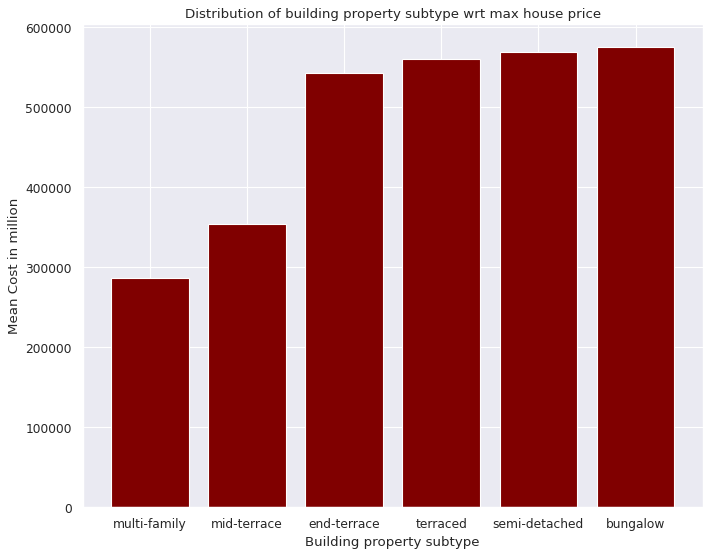

In [26]:
plt.figure(figsize=(10,8), dpi= 80)

plt.bar(df_subtype['building_property_subtype_code'],df_subtype['sold_price'],color='maroon')
plt.xlabel('Building property subtype')
plt.ylabel('Mean Cost in million')
plt.savefig('11.png')
plt.title("Distribution of building property subtype wrt max house price")

bunglow has the highest average cost amongst other building types





---



In [27]:
df = pd.get_dummies(df, drop_first=True, columns=cat_cols)

In [28]:
KNN = KNNImputer(n_neighbors=3)
df_copy = df

# imputing missing values
df1 = KNN.fit_transform(df)

# converting to df 
df1 = pd.DataFrame(df1, columns=df_copy.columns)

In [29]:
df1['yoc_value']=pd.to_numeric(df1['yoc_value'])
df1['sold_date_year']=pd.to_numeric(df1['sold_date_year'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'New home index')

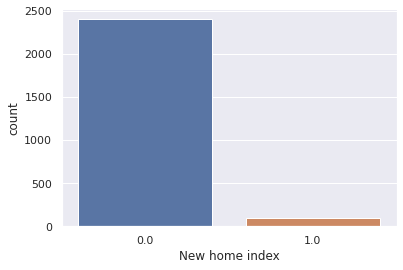

In [30]:
sns.countplot(df1['new_home_ind'])
plt.xlabel('New home index')

we can see that new home indicator is mostly 0 i.e mostly sold houses are not new

Text(0, 0.5, 'Max Cost in million')

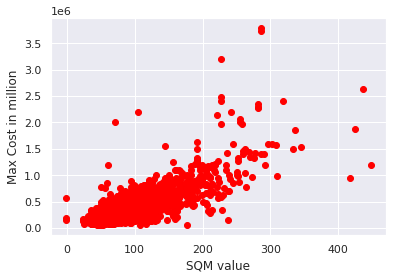

In [31]:
plt.scatter(df1['sqm_value'],df1['sold_price'],color='red')
plt.xlabel('SQM value')
plt.ylabel('Max Cost in million')


as sqm value increases the cost also increases 



Text(0, 0.5, 'Cost in million')

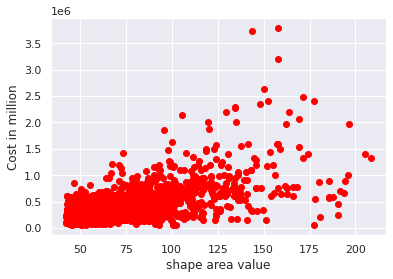

In [32]:
plt.scatter(df1['building_shape_area_value'],df1['sold_price'],color='red')
plt.xlabel('shape area value')
plt.ylabel('Cost in million')

Houses with larger shape area value tend to have higher cost. 




Text(0, 0.5, 'Cost in million')

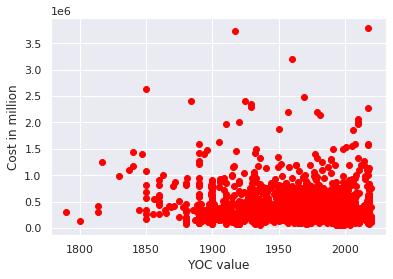

In [33]:
plt.scatter(df1['yoc_value'],df1['sold_price'],color='red')
plt.xlabel('YOC value')
plt.ylabel('Cost in million')

very few houses have construction year before 1850 and those houses have very less sale price. 

Adding a new feature total area of house calculated by adding sqm value and building shape area value

In [34]:
total_area = []
small_area = df1['building_shape_area_value']
sqm_val = df1['sqm_value']
for i in range(len(df1)):
  area = small_area[i] + sqm_val[i]
  total_area.append(area)



In [35]:
df1['total_area']= total_area

Text(0, 0.5, 'Cost in million')

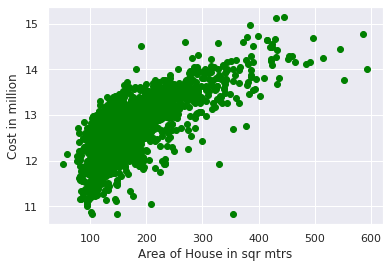

In [36]:
plt.scatter(df1['total_area'],np.log(df1['sold_price']),color='green')
plt.xlabel('Area of House in sqr mtrs')
plt.ylabel('Cost in million')

we can see a linear relation between cost and area. The larger the area of house, the higher is the cost of the house.

Adding a new feature age of the house by subtracting sold date and yoc. 



In [37]:
ageOfHouse = []
yoc = df1['yoc_value']
soldyear = df1['sold_date_year']

for i in range(len(df1)):
  age = soldyear[i] - yoc[i]
  ageOfHouse.append(age)



In [38]:
df1['ageOfHouse']=ageOfHouse

Text(0, 0.5, 'Max Cost in million')

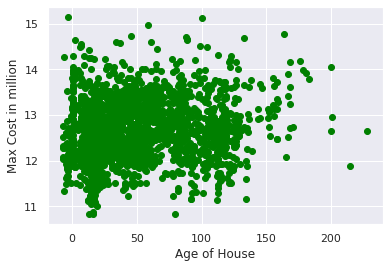

In [39]:
plt.scatter(df1['ageOfHouse'],np.log(df1['sold_price']),color='green')
plt.xlabel('Age of House')
plt.ylabel('Max Cost in million')

Although there is high diversity in prices with houses upto 100 years of age, the price consistently decreases as the age of the house increases, due to depreciation of value over time.


In [40]:
df1['beds_value'] = df1['beds_value'].apply(np.ceil)
df1['baths_value'] = df1['baths_value'].apply(np.ceil)
df1['storey_value'] = df1['storey_value'].apply(np.ceil)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Distribution of Bed values sold')

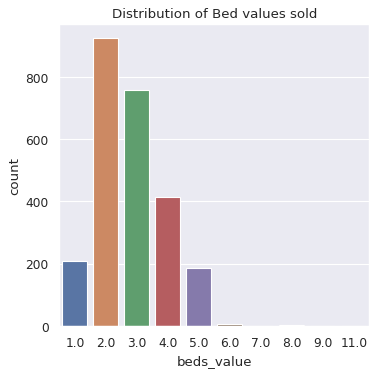

In [41]:
plt.figure(figsize=(5,5), dpi= 80)
sns.countplot(df1['beds_value'])
#plt.xlabel('bed')
#plt.ylabel('Cost')
plt.savefig('12.png')
plt.title("Distribution of Bed values sold")

Majority sales were for 2 and 3 bedrooms houses.
Most preferred number of beds is 2 and 3, but the number of units sold having 2 beds is higher


In [42]:
#df1['beds_value'].value_counts()

In [43]:
df_bed = df1.groupby('beds_value', as_index=False)['sold_price'].max()
df_bed = df_bed.sort_values('sold_price',ascending=False)
#df_bed


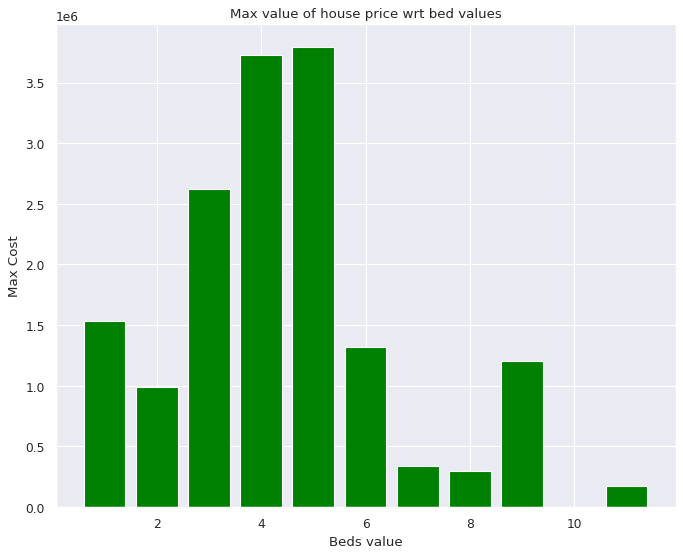

In [44]:
plt.figure(figsize=(10,8), dpi= 80)

plt.bar(df_bed['beds_value'],df_bed['sold_price'],color='green')
plt.xlabel('Beds value')
plt.ylabel('Max Cost')
plt.title("Max value of house price wrt bed values")
plt.savefig('13.png')

4 and 5 bed houses have the maximum cost




/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


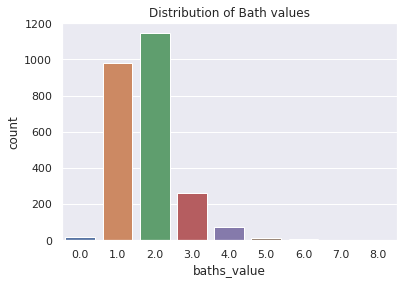

In [45]:
sns.countplot(df1['baths_value'])
plt.title("Distribution of Bath values")
plt.savefig('14.png')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


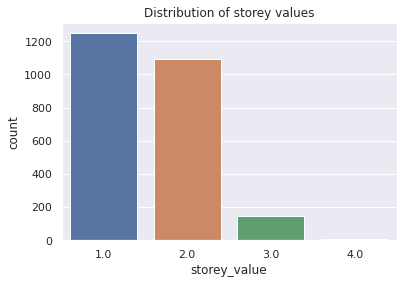

In [46]:
sns.countplot(df1['storey_value'])
plt.title("Distribution of storey values")
plt.savefig('15.png')

In [47]:
Y = df1['sold_price']
X = df1.drop('sold_price',axis=1)

In [48]:
df1 = df1.drop(['thoroughfare_id','id','lat','lon','local_authority_id'],axis=1)
X = df1

In [49]:
cat_cols, num_cols = get_var_dtype_list(df1)


using mimax scaler to normalize the numerical features

In [50]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df1[num_cols] = scaler.fit_transform(df1[num_cols])


In [51]:
df1

,census2016_settlement_geogid,new_home_ind,sold_price,building_shape_area_value,sqm_value,yoc_value,storey_value,beds_value,baths_value,sold_date_year,sold_date_month,sold_date_dayofweek,post_county_name_wicklow,eircode_area_code_A96,eircode_area_code_A98,eircode_area_code_D01,eircode_area_code_D02,eircode_area_code_D04,eircode_area_code_D06,eircode_area_code_D07,eircode_area_code_D08,eircode_area_code_D13,eircode_area_code_D14,eircode_area_code_D18,eircode_area_code_D24,building_property_subtype_code_end-terrace,building_property_subtype_code_mid-terrace,building_property_subtype_code_multi-family,building_property_subtype_code_semi-detached,building_property_subtype_code_terraced,total_area,ageOfHouse
0,0.999806,0.0,0.030708,0.091503,0.217548,0.886463,0.000000,0.0,0.125,0.555556,0.636364,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.189838,0.123404
1,0.000000,1.0,0.132864,0.144906,0.304966,0.991266,0.333333,0.3,0.125,0.888889,0.909091,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.278470,0.034043
2,0.999806,0.0,0.105140,0.160573,0.149627,0.745269,0.333333,0.1,0.250,0.666667,0.454545,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.154743,0.265248
3,0.999806,0.0,0.097997,0.149047,0.177474,0.740902,0.333333,0.2,0.250,0.888889,0.545455,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.174261,0.278014
4,0.999806,0.0,0.053405,0.048404,0.150095,0.755459,0.000000,0.1,0.250,0.888889,0.454545,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.120871,0.263830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,0.999806,0.0,0.113485,0.106459,0.236541,0.586608,0.333333,0.3,0.250,0.666667,0.818182,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.210119,0.419858
2496,0.000000,0.0,0.044140,0.065752,0.294590,0.943231,0.333333,0.1,0.125,0.888889,0.818182,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.245710,0.080851
2497,0.999806,0.0,0.168224,0.400482,0.294931,0.755459,0.333333,0.3,0.375,0.666667,1.000000,0.333333,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.348227,0.255319
2498,0.999806,0.0,0.090788,0.332764,0.172475,0.829694,0.000000,0.2,0.250,0.777778,0.454545,0.500000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.226236,0.187234


In [52]:
#scaler = StandardScaler()
#df1[num_cols] = scaler.fit_transform(df1[num_cols])
#df1

In [53]:
def median_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.median(percentage_error(y_true, y_pred))

def percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return ((y_pred - y_true) / y_true) * 100

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) 

def absolute_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.abs((y_true - y_pred) / y_true) * 100

def median_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.median(np.abs((y_true - y_pred) / y_true)) * 100

In [54]:
x_train,x_test, y_train,y_test= train_test_split(X,Y, train_size=0.8, test_size=0.2,random_state=0)


Using StackingRegressor as base estomators LGBM and XGB and final estimator as Randomforest regressor.

In [55]:

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
estimators = [
    ('lgb', lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)),
    ('xgb', xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1))
]
reg = StackingRegressor(
    estimators=estimators,
    final_estimator=RandomForestRegressor(n_estimators=10,
                                          random_state=42)
)

reg.fit(x_train, y_train)

pred = reg.predict(x_test)

In [56]:
median_absolute_percentage_error(y_test,pred) 

1.4433876811594204

In [57]:
median_percentage_error(y_test,pred)

-0.007907407407409563

In [58]:
mean_absolute_percentage_error(y_test,pred)


0.021750724534504415

In [59]:
absolute_error(y_test,pred)

array([1.67728723e+00, 1.30256842e+00, 7.82926829e+00, 6.58536585e-01,
       2.88019355e+00, 1.35000000e+00, 6.09756098e-01, 3.16988848e-01,
       4.40000000e+00, 1.50000000e+00, 1.42000000e+00, 5.62133333e+00,
       2.70181513e+00, 2.74985591e+00, 3.29457364e+00, 1.58116667e+00,
       2.14285714e+00, 1.56250000e+00, 2.93209877e-01, 4.04040404e+00,
       1.47110333e+00, 2.12007143e+00, 1.45581395e-01, 3.93066100e+00,
       9.38775510e-01, 8.23529412e-01, 1.36363636e-01, 9.83166667e-01,
       6.62460568e-01, 7.72571429e-02, 7.05882353e-01, 1.60000000e+00,
       1.07692308e+00, 3.57142857e-02, 5.81818182e+00, 6.77786667e+00,
       3.27433500e+00, 1.21076233e+00, 6.72368421e-01, 6.02484472e-01,
       5.38720539e-01, 7.29641694e-01, 3.71578947e+00, 4.82181818e+00,
       1.81481481e+00, 1.99297143e+00, 6.12304226e-01, 1.26366667e+00,
       7.93171806e-01, 2.35173824e+00, 4.43181818e+00, 1.53846154e+00,
       2.50000000e+00, 6.57013793e+00, 1.87500000e+00, 4.56431535e-01,
      

If we find out more information from the latitude and longitude of the area we can see how the following places affect the house prices if they are nearby: 
1. Schools
2. Grocery Stores
3. Bus stations/Dart/Luas accessibility
4. Hospitals
5. Corporate offices
6. Lakes/parks/beach/monuments like castles or structures of historic significance.
7. Airports/ seaports
If we could fetch the crime rate of that neighborhood we can also analyse the safety parameter and see how it affects the house rates.

In terms of model accuracy, if we have the above mentioned data along with the data we already have, using deep learning techniques will give good results.